# Feature Engineering and Modelling

#### Create Spark Session

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder\
    .appName("BigData_TG_FE")\
    .config("spark.sql.shuffle.partitions",6)\
    .config("spark.sql.repl.eagereval.enabled",True)\
    .getOrCreate()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1685149478290_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Reduce Data

In [2]:
bikes_and_stations = spark.read.parquet("s3://abdbucketjddc/dataout/londonbikes")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
seed = 5
with_replacement = False
fraction = 0.20          # reduce to 20%
test_bikes = bikes_and_stations.sample(withReplacement=with_replacement, 
                                               fraction=fraction, seed=seed)

test_bikes_count = test_bikes.count()
test_bikes_count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

6443571

In [10]:
test_bikes.describe().show(vertical=True)

-RECORD 0--------------------------------
 summary          | count                
 start_station_id | 600715               
 Hour             | 600715               
 Day              | 600715               
 DayofWeek        | 600715               
 Month            | 600715               
 Year             | 600715               
 dateconc         | 600715               
 sum_duration     | 600715               
 avg_duration     | 600715               
 num_rentals      | 600715               
 station_id       | 600647               
 station_name     | 600647               
 longitude        | 600647               
 latitude         | 600647               
 area_cleaned     | 600647               
 date             | 600715               
 sunshine         | 600715               
 mean             | 600715               
 cloud            | 600715               
 gr               | 600715               
 maxt             | 600715               
 mint             | 600715        

In [11]:
test_bikes.printSchema()

root
 |-- start_station_id: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- DayofWeek: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- dateconc: string (nullable = true)
 |-- sum_duration: double (nullable = true)
 |-- avg_duration: double (nullable = true)
 |-- num_rentals: long (nullable = true)
 |-- station_id: integer (nullable = true)
 |-- station_name: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- area_cleaned: string (nullable = true)
 |-- date: integer (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- mean: double (nullable = true)
 |-- cloud: double (nullable = true)
 |-- gr: double (nullable = true)
 |-- maxt: double (nullable = true)
 |-- mint: double (nullable = true)
 |-- prec: double (nullable = true)
 |-- press: double (nullable = true)



In [5]:
from pyspark.sql.functions import col

test_bikes = (test_bikes
              .withColumn('Day', col('Day').cast('integer'))
              .withColumn('dateconc', col('dateconc').cast('integer'))
                         
             )


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
test_bikes.printSchema()

root
 |-- start_station_id: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayofWeek: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- dateconc: integer (nullable = true)
 |-- sum_duration: double (nullable = true)
 |-- avg_duration: double (nullable = true)
 |-- num_rentals: long (nullable = true)
 |-- station_id: integer (nullable = true)
 |-- station_name: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- area_cleaned: string (nullable = true)
 |-- date: integer (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- mean: double (nullable = true)
 |-- cloud: double (nullable = true)
 |-- gr: double (nullable = true)
 |-- maxt: double (nullable = true)
 |-- mint: double (nullable = true)
 |-- prec: double (nullable = true)
 |-- press: double (nullable = true)



In [46]:
string_columns = ['station_name', 'area_cleaned']

cols_interest_corr = [x for x in test_bikes.columns if x not in string_columns]

test_bikes_corr = test_bikes.select(cols_interest_corr)

test_bikes_corr.printSchema()

root
 |-- start_station_id: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayofWeek: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- dateconc: integer (nullable = true)
 |-- sum_duration: double (nullable = true)
 |-- avg_duration: double (nullable = true)
 |-- num_rentals: long (nullable = true)
 |-- station_id: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- date: integer (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- mean: double (nullable = true)
 |-- cloud: double (nullable = true)
 |-- gr: double (nullable = true)
 |-- maxt: double (nullable = true)
 |-- mint: double (nullable = true)
 |-- prec: double (nullable = true)
 |-- press: double (nullable = true)



In [47]:
from pyspark.ml.stat import Correlation

vector_col = 'corr_features'
cols_corr = test_bikes_corr.columns
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col)
df_vector = assembler.transform(test_bikes_corr).select(vector_col)

corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

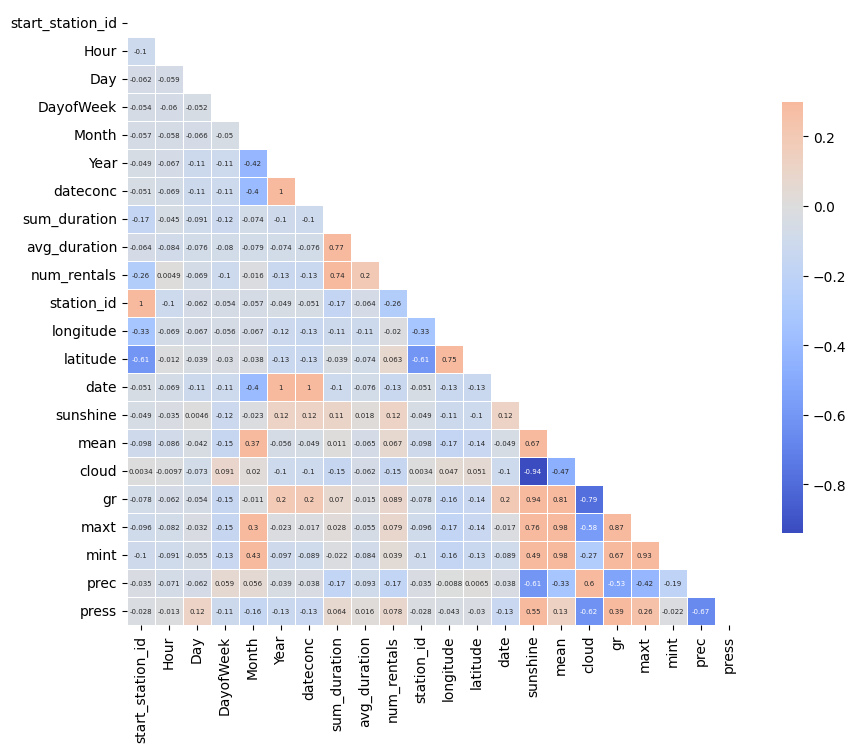

In [48]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

def plotCorrelationMatrix(df, annot=False):
    # compute the correlation matrix
    corr = df.corr()
    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 8))
    # generate a custom colormap
    #cmap = sns.divergent_palette(230, 20, as_cmap=True)

    cmap='coolwarm'
    # draw the heatmap with the mask and correct aspect ratio
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=annot,
    square=True, linewidths=.7, cbar_kws={"shrink": .7},annot_kws={"size": 5})

df_plot = pd.DataFrame(data = corr_matrix, index=cols_corr, columns=cols_corr)
plotCorrelationMatrix(df_plot, annot=True)
plt.show()

As a rule, we are going to exclude some features that combined with others, result in high correlations (0.7)

In [6]:
excluded_features = ['start_station_id', 'dateconc', 'Year', 'gr', 'maxt', 'mint', 'sum_duration', 'avg_duration']

included_features = [x for x in test_bikes.columns if x not in excluded_features]

featured_df = test_bikes.select(included_features)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
from pyspark.ml.stat import Correlation

string_columns = ['station_name', 'area_cleaned']

cols_interest_corr = [x for x in featured_df.columns if x not in string_columns]

featured_corr = featured_df.select(cols_interest_corr)

vector_col = 'corr_features'
cols_corr = featured_corr.columns
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col)
df_vector = assembler.transform(featured_corr).select(vector_col)

corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

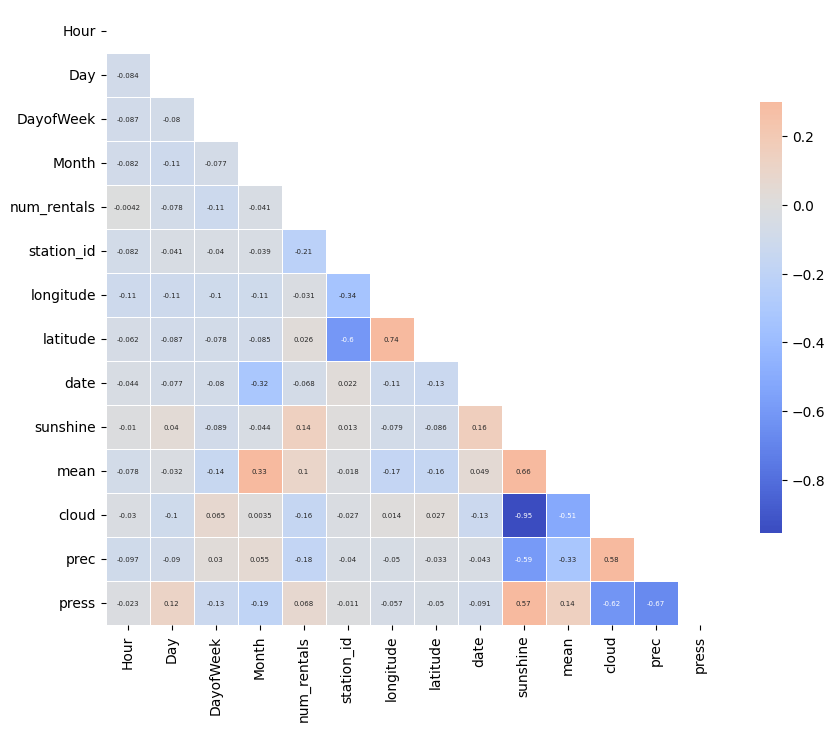

In [52]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

def plotCorrelationMatrix(df, annot=False):
    # compute the correlation matrix
    corr = df.corr()
    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 8))
    # generate a custom colormap
    #cmap = sns.divergent_palette(230, 20, as_cmap=True)

    cmap='coolwarm'
    # draw the heatmap with the mask and correct aspect ratio
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=annot,
    square=True, linewidths=.7, cbar_kws={"shrink": .7},annot_kws={"size": 5})

df_plot = pd.DataFrame(data = corr_matrix, index=cols_corr, columns=cols_corr)
plotCorrelationMatrix(df_plot, annot=True)
plt.show()

Save the current df in parquet:

In [6]:
featured_df.write.mode("overwrite").parquet("s3://abdbucketjddc/dataout/featured")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Ler o ficheiro

In [2]:
from pyspark.sql.functions import col

test_df = spark.read.parquet("s3://abdbucketjddc/dataout/featured")
test_df = test_df.orderBy(col('date'), col('Hour'))
test_df.printSchema()
test_df.show(5, vertical=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Hour: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayofWeek: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- end_station_id: double (nullable = true)
 |-- num_rentals: long (nullable = true)
 |-- station_id: integer (nullable = true)
 |-- station_name: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- area_cleaned: string (nullable = true)
 |-- date: integer (nullable = true)
 |-- sunshine: double (nullable = true)
 |-- mean: double (nullable = true)
 |-- cloud: double (nullable = true)
 |-- prec: double (nullable = true)
 |-- press: double (nullable = true)

-RECORD 0------------------------------
 Hour           | 0                    
 Day            | 28                   
 DayofWeek      | 4                    
 Month          | 12                   
 end_station_id | 337.0                
 num_rentals    | 1                    
 station_id     | 524                  

## Criar a Pipeline

In [5]:
# The pipeline holds four stages as set above: 
#  1. string_indexer 
#  2. ohe_encoder
#  3. vec_assembler (related to assembling features into vector) 
#  4. Random Forest Regressor/Decision Tree Regressor/Gradient Boosted Tree Regressor (related to ML estimator)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Aplicar o VectorIndexer e dividir os dados:

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import RegressionEvaluator

# Define the columns you want to index
columns_to_index = ["station_name", "area_cleaned"]
non_categorical_cols = [x for x in test_df.columns if x not in columns_to_index]
index_output_cols = [x + ' Index' for x in columns_to_index]
ohe_output_cols = [x + ' OHE' for x in columns_to_index]


# Create a list of StringIndexer stages for each column
string_indexer = StringIndexer(inputCols=columns_to_index, outputCols=index_output_cols, handleInvalid="skip")

ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)

assembler_inputs = ohe_output_cols + non_categorical_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
assembler_inputs

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['station_name OHE', 'area_cleaned OHE', 'Hour', 'Day', 'DayofWeek', 'Month', 'end_station_id', 'num_rentals', 'station_id', 'longitude', 'latitude', 'date', 'sunshine', 'mean', 'cloud', 'prec', 'press']

In [7]:
# Split the data into training and test sets (30% held out for testing)
#(trainingData, testData) = test_df.randomSplit([0.7, 0.3])

timestamp_threshold_1 = '20190601'

timestamp_threshold_2 = '20191231'

# Time-series 1: Timestamps before the threshold
training_set = test_df.filter(col('date') < timestamp_threshold_1)

# Time-series 2: Timestamps after or equal to the threshold
test_set = test_df.filter((col('date') >= timestamp_threshold_1) & (col('date') < timestamp_threshold_2))

stream_set = test_df.filter(col('date') > timestamp_threshold_2)

test_set.write.mode("overwrite").parquet("s3://abdbucketjddc/dataout/test")

stream_set.write.mode("overwrite").parquet("s3://abdbucketjddc/dataout/stream")

# Print the number of rows in each part
print(f"There are {training_set.count()} rows in the training set and {test_set.count()} in the test set.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are 4232906 rows in the training set and 1073630 in the test set.

## Random Forest Regressor

#### Treinar o modelo:

In [38]:
import time

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
start_time = time.time()

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="features", labelCol='num_rentals')

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(training_set)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Execution time: 394.0432870388031 seconds

#### Save pipeline

In [42]:
# We can save the pipeline for further use should it be required

pipeline.write().overwrite().save("s3://abdbucketjddc/dataout/pipeline-RF")

model.write().overwrite().save('s3://abdbucketjddc/dataout/model-RF')
# later on, it can be loaded anywhere

# check the content of created directories 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Fazer previsões:

In [43]:
# Make predictions.
predictions = model.transform(test_set)

# Select example rows to display.
predictions.select("prediction", "num_rentals", "features", "date", "area_cleaned", "hour").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----------+--------------------+--------+------------+----+
|        prediction|num_rentals|            features|    date|area_cleaned|hour|
+------------------+-----------+--------------------+--------+------------+----+
|1.0044011868824654|          1|(924,[232,808,910...|20190601|     Mayfair|   0|
|1.0044011868824654|          1|(924,[8,800,910,9...|20190601|  Shoreditch|   0|
|2.5780898901457485|          3|(924,[608,840,910...|20190601| WestChelsea|   0|
|1.0044011868824654|          1|(924,[72,891,910,...|20190601|  ShadThames|   0|
|2.0554036695223377|          2|(924,[357,833,910...|20190601|     Stepney|   0|
+------------------+-----------+--------------------+--------+------------+----+
only showing top 5 rows

#### Avaliar os resultados:

In [44]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="num_rentals", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data = 0.213317

In [45]:
from pyspark.sql.functions import sum,avg,max,count

cols_to_plot = ['date', 'area_cleaned', 'hour']

grouped = predictions.groupBy(cols_to_plot) \
            .agg(sum("num_rentals").alias("real_rentals"), \
                 sum("prediction").alias("pred_rentals")
                 )

grouped = grouped.sort(col('pred_rentals'), ascending=False)
grouped.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------------+----+------------+------------------+
|    date|area_cleaned|hour|real_rentals|      pred_rentals|
+--------+------------+----+------------+------------------+
|20190803|    HydePark|  16|         121|100.98464980579166|
|20190804|    HydePark|  15|         108| 89.96900434533948|
|20190623|    HydePark|  15|         113| 87.92206530026067|
|20190919|    Waterloo|   8|          91|  85.9882936471687|
|20190624|     Holborn|  17|          85| 85.00530974774267|
+--------+------------+----+------------+------------------+
only showing top 5 rows

## Decision Tree Regressor

#### Treinar o modelo:

In [46]:
from pyspark.ml.regression import DecisionTreeRegressor

start_time = time.time()

# Train a RandomForest model.
dt = DecisionTreeRegressor(featuresCol="features", labelCol='num_rentals')

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler, dt])

# Train model.  This also runs the indexer.
model = pipeline.fit(training_set)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Execution time: 277.1463677883148 seconds

#### Save pipeline

In [47]:
# We can save the pipeline for further use should it be required

pipeline.write().overwrite().save("s3://abdbucketjddc/dataout/pipeline-DT")

model.write().overwrite().save('s3://abdbucketjddc/dataout/model-DT')
# later on, it can be loaded anywhere

# check the content of created directories 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Fazer previsões:

In [48]:
# Make predictions.
predictions = model.transform(test_set)

# Select example rows to display.
predictions.select("prediction", "num_rentals", "features", "date", "area_cleaned", "hour").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------+--------------------+--------+---------------+----+
|prediction|num_rentals|            features|    date|   area_cleaned|hour|
+----------+-----------+--------------------+--------+---------------+----+
|       1.0|          1|(924,[56,812,910,...|20190601|SouthKensington|   0|
|       1.0|          1|(924,[7,820,910,9...|20190601|           Bank|   0|
|       2.0|          2|(924,[177,885,910...|20190601| HackneyCentral|   0|
|       6.0|          6|(924,[57,802,910,...|20190601|         Strand|   0|
|       1.0|          1|(924,[15,821,910,...|20190601|        StLukes|   0|
+----------+-----------+--------------------+--------+---------------+----+
only showing top 5 rows

#### Avaliar os resultados:

In [49]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="num_rentals", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data = 0.0460345

In [50]:
from pyspark.sql.functions import sum,avg,max,count

cols_to_plot = ['date', 'area_cleaned', 'hour']

grouped = predictions.groupBy(cols_to_plot) \
            .agg(sum("num_rentals").alias("real_rentals"), \
                 sum("prediction").alias("pred_rentals")
                 )

grouped = grouped.sort(col('pred_rentals'), ascending=False)
grouped.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------------+----+------------+------------------+
|    date|area_cleaned|hour|real_rentals|      pred_rentals|
+--------+------------+----+------------+------------------+
|20190803|    HydePark|  16|         121|122.25832507491765|
|20190623|    HydePark|  15|         113|116.08454421327333|
|20190804|    HydePark|  15|         108|104.12330451211427|
|20190622|    HydePark|  17|          86| 91.72499365147557|
|20190919|    Waterloo|   8|          91|              91.0|
+--------+------------+----+------------+------------------+
only showing top 5 rows

## Gradient-boosted tree regression

#### Treinar o modelo:

In [51]:
from pyspark.ml.regression import GBTRegressor

start_time = time.time()

# Train a RandomForest model.
gbt = GBTRegressor(featuresCol="features", labelCol='num_rentals', maxIter=3)

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler, gbt])

# Train model.  This also runs the indexer.
model = pipeline.fit(training_set)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Execution time: 674.7225520610809 seconds

#### Save pipeline

In [52]:
# We can save the pipeline for further use should it be required

pipeline.write().overwrite().save("s3://abdbucketjddc/dataout/pipeline-GBT")

model.write().overwrite().save('s3://abdbucketjddc/dataout/model-GBT')
# later on, it can be loaded anywhere

# check the content of created directories 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Fazer previsões:

In [8]:
from pyspark.ml import PipelineModel

model = PipelineModel.load('s3://abdbucketjddc/dataout/model-GBT/')

# Make predictions.
predictions = model.transform(test_set)

# Select example rows to display.
predictions.select("prediction", "num_rentals", "features", "date", "area_cleaned", "hour").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------+--------------------+--------+---------------+----+
|prediction|num_rentals|            features|    date|   area_cleaned|hour|
+----------+-----------+--------------------+--------+---------------+----+
|       1.0|          1|(924,[56,812,910,...|20190601|SouthKensington|   0|
|       1.0|          1|(924,[7,820,910,9...|20190601|           Bank|   0|
|       2.0|          2|(924,[177,885,910...|20190601| HackneyCentral|   0|
|       6.0|          6|(924,[57,802,910,...|20190601|         Strand|   0|
|       1.0|          1|(924,[15,821,910,...|20190601|        StLukes|   0|
+----------+-----------+--------------------+--------+---------------+----+
only showing top 5 rows

#### Avaliar os resultados:

In [54]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="num_rentals", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data = 0.0345221

In [9]:
from pyspark.sql.functions import sum,avg,max,count

cols_to_plot = ['date', 'area_cleaned', 'hour']

grouped = predictions.groupBy(cols_to_plot) \
            .agg(sum("num_rentals").alias("real_rentals"), \
                 sum("prediction").alias("pred_rentals")
                 )

grouped = grouped.sort(col('pred_rentals'), ascending=False)
grouped.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------------+----+------------+------------------+
|    date|area_cleaned|hour|real_rentals|      pred_rentals|
+--------+------------+----+------------+------------------+
|20190803|    HydePark|  16|         121|121.82605982283359|
|20190623|    HydePark|  15|         113|116.87663814648727|
|20190804|    HydePark|  15|         108|111.01444502707302|
|20190601|    HydePark|  16|          99|102.67686684701584|
|20190919|    Waterloo|   8|          91|              91.0|
+--------+------------+----+------------+------------------+
only showing top 5 rows

### Save for future visualizations

In [10]:
grouped.write.mode("overwrite").parquet("s3://abdbucketjddc/dataout/predicted")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…